In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing


From the previous study, one thing we can conclude is that during the period of 2019-2022, due to Covid, the amount of reviews, either positive or negative, drastically dropped.
With this in mind, let's try to do the following: let's tag each review between 2020 and 2022 as "covid" and let's see if the ARIMA model makes a new prediction

### Mark reviews as 'Covid'
Through searching on the Internet, we concluded that it was on around march of 2020 that a lockdown was set in New Orleans and it was lifted in May of 2022. Therefore, we decided to consider all the reviews from March 1st of 2020 to May of 2022 as 'Covid' and the rest as 'Non-Covid'.

In [82]:
# Load the data from the JSON file
with open('./datasets/review_dataset_new_orleans_sentiment.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data = "[" + ','.join(data) + "]"

    # Load the data into a DataFrame
    data = pd.read_json(data)

print(data.head())

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Tag reviews between March 2020 and 2022 as "COVID"
data['covid'] = data['date'].apply(lambda x: 'COVID' if (x >= datetime(2020, 3, 1)) and (x <= datetime(2022, 12, 31)) else 'non-COVID')

# Check the taggings
print(data['covid'].value_counts())



/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_55829/1482044186.py:8: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_json(data)


                    review_id  sentiment                date
0  rev_Sx8TMOWLNuJBWer-0pcmoA          1 2017-01-14 20:54:15
1  rev_6AxgBCNX_PNTOxmbRSwcKQ          1 2015-01-03 23:21:18
2  rev_z0osLHDvXvzfm57D4DmD2Q          1 2016-11-22 00:22:53
3  rev_jC-fGfx-YLqxVBcyTAd4Pw          1 2013-12-29 02:37:42
4  rev_Ki90-hauSIfW_7sBuBBqfA          1 2014-06-11 14:55:14
covid
non-COVID    569278
COVID         66086
Name: count, dtype: int64


### Separate data (as 'pre-COVID' and 'COVID') and aggregate data by year

To ensure that categorizing reviews as "covid" has a significant impact on the analysis, we must explicitly account for the COVID period in the model. This includes dividing the data into pre-COVID and COVID periods.

In [91]:
data['year'] = data['date'].dt.year
data['positive'] = data['sentiment'].apply(lambda x: 1 if x == 1 else 0)
data['negative'] = data['sentiment'].apply(lambda x: 1 if x == 0 else 0)

yearly_data = data.groupby('year').agg({'positive': 'sum', 'negative': 'sum'}).reset_index()
# add the covid column to the yearly data
yearly_data['covid'] = yearly_data['year'].apply(lambda x: 'COVID' if x >= 2020 else 'non-COVID')

# Apply rolling average to smooth the data
window_size = 3
yearly_data['positive_smoothed'] = yearly_data['positive'].rolling(window=window_size).mean()
yearly_data['negative_smoothed'] = yearly_data['negative'].rolling(window=window_size).mean()

yearly_data['positive_smoothed'] = yearly_data['positive_smoothed'].fillna(0)
yearly_data['negative_smoothed'] = yearly_data['negative_smoothed'].fillna(0)

# Separate the data into pre-COVID and COVID periods
pre_covid_data = yearly_data[yearly_data['covid'] == 'non-COVID']
# for covid data add the data tagged as covid and non-covid
covid_data = yearly_data[yearly_data['covid'] == 'COVID']
covid_data = pd.concat([covid_data, yearly_data[yearly_data['covid'] == 'non-COVID']])

# print the data
print(pre_covid_data.head())
print(covid_data.head())


   year  positive  negative      covid  positive_smoothed  negative_smoothed
0  2005       266        25  non-COVID           0.000000           0.000000
1  2006       285        13  non-COVID           0.000000           0.000000
2  2007      1192        41  non-COVID         581.000000          26.333333
3  2008      3101        91  non-COVID        1526.000000          48.333333
4  2009      6553       168  non-COVID        3615.333333         100.000000
    year  positive  negative      covid  positive_smoothed  negative_smoothed
15  2020     33453      1789      COVID       66404.333333        3230.000000
16  2021     39635      2290      COVID       51433.333333        2649.000000
17  2022      2114       108      COVID       25067.333333        1395.666667
0   2005       266        25  non-COVID           0.000000           0.000000
1   2006       285        13  non-COVID           0.000000           0.000000


### Fit new ARIMA Model and new Predictions

In [92]:
# Fit ARIMA model for positive sentiment (pre-COVID)
positive_model_pre_covid = ARIMA(pre_covid_data['positive_smoothed'].dropna(), order=(1, 0, 1)).fit()
print("Pre-COVID Positive Sentiment Model Summary")
print(positive_model_pre_covid.summary())

# Fit ARIMA model for positive sentiment (COVID period)
positive_model_covid = ARIMA(yearly_data['positive_smoothed'].dropna(), order=(1, 0, 1)).fit()
print("COVID Period Positive Sentiment Model Summary")
print(positive_model_covid.summary())

# Forecast for the next 5 years for positive sentiment (pre-COVID)
positive_forecast_pre_covid = positive_model_pre_covid.forecast(steps=8)
print('Positive Sentiment Forecast (Pre-COVID):', positive_forecast_pre_covid)

# Forecast for the next 5 years for positive sentiment (COVID period)
positive_forecast_covid = positive_model_covid.forecast(steps=5)
print('Positive Sentiment Forecast (COVID Period):', positive_forecast_covid)

# Repeat the same process for negative sentiment
negative_model_pre_covid = ARIMA(pre_covid_data['negative_smoothed'].dropna(), order=(1, 0, 1)).fit()
print("Pre-COVID Negative Sentiment Model Summary")
print(negative_model_pre_covid.summary())

negative_model_covid = ARIMA(yearly_data['negative_smoothed'].dropna(), order=(1, 0, 1)).fit()
print("COVID Period Negative Sentiment Model Summary")
print(negative_model_covid.summary())

negative_forecast_pre_covid = negative_model_pre_covid.forecast(steps=8)
print('Negative Sentiment Forecast (Pre-COVID):', negative_forecast_pre_covid)

negative_forecast_covid = negative_model_covid.forecast(steps=5)
print('Negative Sentiment Forecast (COVID Period):', negative_forecast_covid)

Pre-COVID Positive Sentiment Model Summary
                               SARIMAX Results                                
Dep. Variable:      positive_smoothed   No. Observations:                   15
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -148.083
Date:                Sat, 18 May 2024   AIC                            304.165
Time:                        17:39:12   BIC                            306.997
Sample:                             0   HQIC                           304.135
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.003e+04   7.37e+04      0.407      0.684   -1.14e+05    1.75e+05
ar.L1          0.9827      0.100      9.789      0.000       0.786       1.179
ma.L1    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Compare forecasts

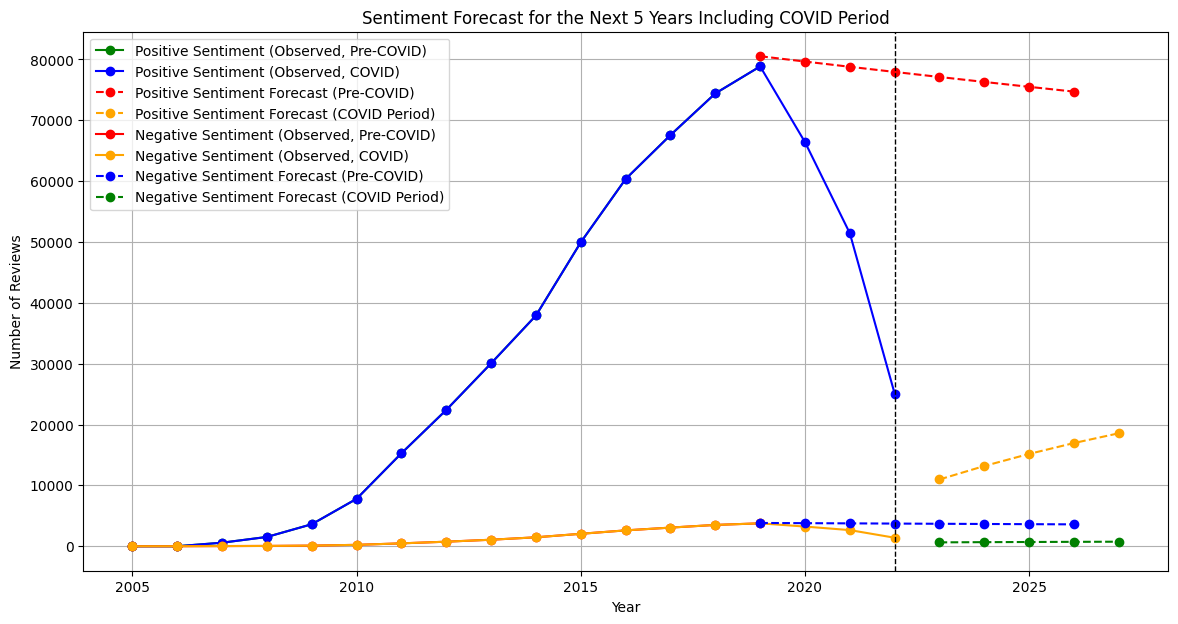

In [93]:
# Extend the yearly data to include forecasted years
forecast_years = list(range(yearly_data['year'].max() + 1, yearly_data['year'].max() + 6))
forecast_index = pd.concat([yearly_data['year'], pd.Series(forecast_years)], ignore_index=True)

pre_covid_foreacast_years = list(range(pre_covid_data['year'].max(), pre_covid_data['year'].max() + 8))
pre_covid_foreacast_index = pd.concat([pre_covid_data['year'], pd.Series(pre_covid_foreacast_years)], ignore_index=True)

# Append the forecasted data to the original data
pre_covid_data_date = pd.concat([pre_covid_data, pd.DataFrame({'year': pre_covid_foreacast_years, 'positive_smoothed': positive_forecast_pre_covid, 'negative_smoothed': negative_forecast_pre_covid})], ignore_index=True)
covid_data_date = pd.concat([yearly_data, pd.DataFrame({'year': forecast_years, 'positive_smoothed': positive_forecast_covid, 'negative_smoothed': negative_forecast_covid})], ignore_index=True)

# Handle NaN values
pre_covid_data_date = pre_covid_data_date.dropna()
covid_data_date = covid_data_date.dropna()

plt.figure(figsize=(14, 7))

# Positive Sentiment
plt.plot(pre_covid_data_date['year'], pre_covid_data_date['positive_smoothed'], label='Positive Sentiment (Observed, Pre-COVID)', color='green', marker='o')
plt.plot(covid_data_date['year'], covid_data_date['positive_smoothed'], label='Positive Sentiment (Observed, COVID)', color='blue', marker='o')
plt.plot(pre_covid_foreacast_years, positive_forecast_pre_covid, label='Positive Sentiment Forecast (Pre-COVID)', color='red', linestyle='dashed', marker='o')
plt.plot(forecast_years, positive_forecast_covid, label='Positive Sentiment Forecast (COVID Period)', color='orange', linestyle='dashed', marker='o')

# Negative Sentiment
plt.plot(pre_covid_data_date['year'], pre_covid_data_date['negative_smoothed'], label='Negative Sentiment (Observed, Pre-COVID)', color='red', marker='o')
plt.plot(covid_data_date['year'], covid_data_date['negative_smoothed'], label='Negative Sentiment (Observed, COVID)', color='orange', marker='o')
plt.plot(pre_covid_foreacast_years, negative_forecast_pre_covid, label='Negative Sentiment Forecast (Pre-COVID)', color='blue', linestyle='dashed', marker='o')
plt.plot(forecast_years, negative_forecast_covid, label='Negative Sentiment Forecast (COVID Period)', color='green', linestyle='dashed', marker='o')

# Add vertical line to separate observed and forecasted periods
plt.axvline(x=2022, color='black', linestyle='--', linewidth=1)

plt.title('Sentiment Forecast for the Next 5 Years Including COVID Period')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend()
plt.grid(True)
plt.show()

As shown in the graph, when we're only working with 'non-COVID' reviews, it results in a clear difference in the forecast of both positive and negative reviews. Without considering the covid reviews, it is clear that, by using the ARIMA model, the number of positive reviews will start to decrease since 2020 until 2027, leading to a sense of stability and probably declining hype of the platform, as opposed to the drastic decline of reviews in 2020 due to the pandemic and the forecasted slow rise in 2022.

Regarding bad reviews, while we can still confirm the trend of negative reviews flatlining, where the only notable change is that the quantity of negative reviews will be higher than those produced using Covid data for training.

In [97]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Pre-COVID Positive Sentiment Metrics
mae_pre_covid_positive = mean_absolute_error(pre_covid_data['positive_smoothed'], positive_model_pre_covid.fittedvalues)
mse_pre_covid_positive = mean_squared_error(pre_covid_data['positive_smoothed'], positive_model_pre_covid.fittedvalues)
rmse_pre_covid_positive = mean_squared_error(pre_covid_data['positive_smoothed'], positive_model_pre_covid.fittedvalues, squared=False)
mape_pre_covid_positive = mean_absolute_percentage_error(pre_covid_data['positive_smoothed'], positive_model_pre_covid.fittedvalues)

# Pre-COVID Negative Sentiment Metrics
mae_pre_covid_negative = mean_absolute_error(pre_covid_data['negative_smoothed'], negative_model_pre_covid.fittedvalues)
mse_pre_covid_negative = mean_squared_error(pre_covid_data['negative_smoothed'], negative_model_pre_covid.fittedvalues)
rmse_pre_covid_negative = mean_squared_error(pre_covid_data['negative_smoothed'], negative_model_pre_covid.fittedvalues, squared=False)
mape_pre_covid_negative = mean_absolute_percentage_error(pre_covid_data['negative_smoothed'], negative_model_pre_covid.fittedvalues)

# COVID Positive Sentiment Metrics
mae_covid_positive = mean_absolute_error(yearly_data['positive_smoothed'], positive_model_covid.fittedvalues)
mse_covid_positive = mean_squared_error(yearly_data['positive_smoothed'], positive_model_covid.fittedvalues)
rmse_covid_positive = mean_squared_error(yearly_data['positive_smoothed'], positive_model_covid.fittedvalues, squared=False)
mape_covid_positive = mean_absolute_percentage_error(yearly_data['positive_smoothed'], positive_model_covid.fittedvalues)

# COVID Negative Sentiment Metrics
mae_covid_negative = mean_absolute_error(yearly_data['negative_smoothed'], negative_model_covid.fittedvalues)
mse_covid_negative = mean_squared_error(yearly_data['negative_smoothed'], negative_model_covid.fittedvalues)
rmse_covid_negative = mean_squared_error(yearly_data['negative_smoothed'], negative_model_covid.fittedvalues, squared=False)
mape_covid_negative = mean_absolute_percentage_error(yearly_data['negative_smoothed'], negative_model_covid.fittedvalues)

print("Pre-COVID Positive Sentiment Metrics:")
print(f"MAE: {mae_pre_covid_positive}")
print(f"MSE: {mse_pre_covid_positive}")
print(f"RMSE: {rmse_pre_covid_positive}")
print(f"MAPE: {mape_pre_covid_positive}")

print("Pre-COVID Negative Sentiment Metrics:")
print(f"MAE: {mae_pre_covid_negative}")
print(f"MSE: {mse_pre_covid_negative}")
print(f"RMSE: {rmse_pre_covid_negative}")
print(f"MAPE: {mape_pre_covid_negative}")

# AIC and BIC are calculated for the overall model during the fitting process and do not directly distinguish between pre-COVID and COVID periods.
print(f"AIC (Positive Sentiment): {positive_model_pre_covid.aic}")
print(f"BIC (Positive Sentiment): {positive_model_pre_covid.bic}")
print(f"AIC (Negative Sentiment): {negative_model_pre_covid.aic}")
print(f"BIC (Negative Sentiment): {negative_model_pre_covid.bic}")

Pre-COVID Positive Sentiment Metrics:
MAE: 4921.783651822333
MSE: 74553447.66420816
RMSE: 8634.43383576527
MAPE: inf
Pre-COVID Negative Sentiment Metrics:
MAE: 256.92936071300636
MSE: 261649.55848585302
RMSE: 511.516919061191
MAPE: inf
AIC (Positive Sentiment): 304.1651096926626
BIC (Positive Sentiment): 306.99731049707145
AIC (Negative Sentiment): 212.2057927502176
BIC (Negative Sentiment): 215.03799355462644


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

Now let's check if, with this tagging method, the Exponential Smoothing model shows better results. As we have seen in the previous notebook, this model, especially in the forecast of positive reviews, was greatly affected by the pandemic.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pre-COVID Positive Sentiment Model Summary
Positive Sentiment Forecast (Pre-COVID): 15     85384.050493
16     91540.325369
17     97696.600244
18    103852.875120
19    110009.149996
20    116165.424872
21    122321.699748
22    128477.974624
dtype: float64
Positive Sentiment Forecast (COVID Period): 18     -1142.510928
19    -27409.114509
20    -53675.718089
21    -79942.321670
22   -106208.925251
dtype: float64
Pre-COVID Negative Sentiment Model Summary
Negative Sentiment Forecast (Pre-COVID): 15    4064.966633
16    4355.810757
17    4646.654880
18    4937.499004
19    5228.343127
20    5519.187251
21    5810.031374
22    6100.875498
dtype: float64
Negative Sentiment Forecast (COVID Period): 18     197.771787
19   -1002.348978
20   -2202.469743
21   -3402.590507
22   -4602.711272
dtype: float64


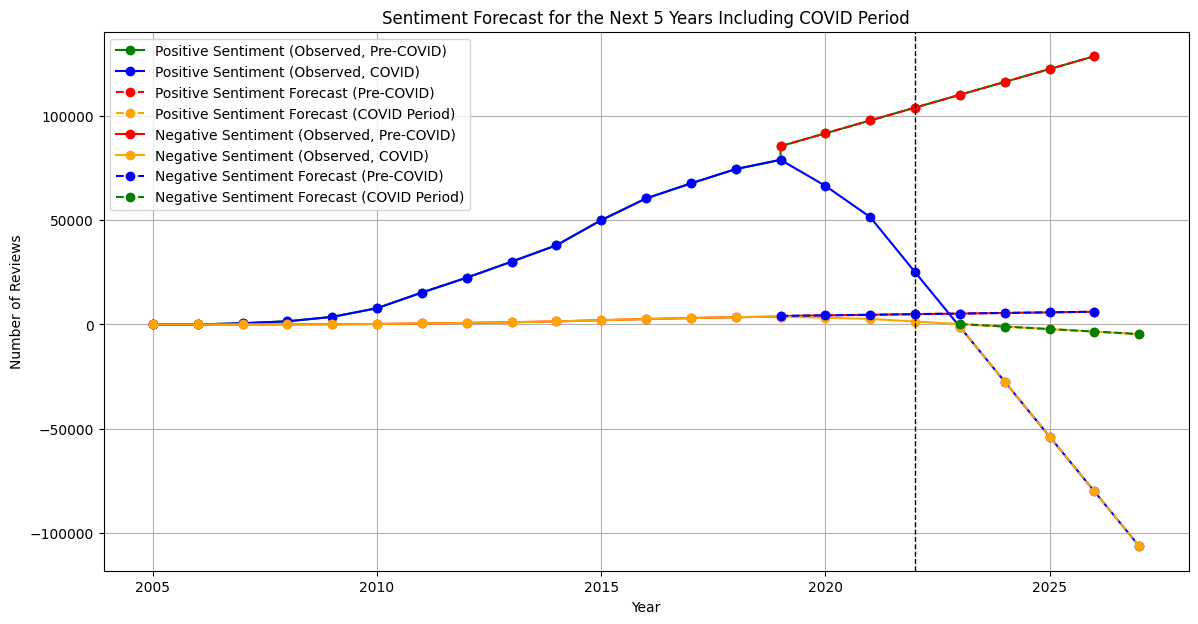

In [101]:
# Fit the Exponential Smoothing model for positive sentiment (pre-COVID)
positive_model_pre_covid = ExponentialSmoothing(pre_covid_data['positive_smoothed'].dropna(), trend='add').fit()
print("Pre-COVID Positive Sentiment Model Summary")

# Fit the Exponential Smoothing model for positive sentiment (COVID period)
positive_model_covid = ExponentialSmoothing(yearly_data['positive_smoothed'].dropna(), trend='add').fit()

# Forecast for the next 5 years for positive sentiment (pre-COVID)
positive_forecast_pre_covid = positive_model_pre_covid.forecast(steps=8)
print('Positive Sentiment Forecast (Pre-COVID):', positive_forecast_pre_covid)

# Forecast for the next 5 years for positive sentiment (COVID period)
positive_forecast_covid = positive_model_covid.forecast(steps=5)
print('Positive Sentiment Forecast (COVID Period):', positive_forecast_covid)

# Repeat the same process for negative sentiment
negative_model_pre_covid = ExponentialSmoothing(pre_covid_data['negative_smoothed'].dropna(), trend='add').fit()
print("Pre-COVID Negative Sentiment Model Summary")

negative_model_covid = ExponentialSmoothing(yearly_data['negative_smoothed'].dropna(), trend='add').fit()

negative_forecast_pre_covid = negative_model_pre_covid.forecast(steps=8)
print('Negative Sentiment Forecast (Pre-COVID):', negative_forecast_pre_covid)

negative_forecast_covid = negative_model_covid.forecast(steps=5)
print('Negative Sentiment Forecast (COVID Period):', negative_forecast_covid)

# Append the forecasted data to the original data
pre_covid_data_date = pd.concat([pre_covid_data, pd.DataFrame({'year': pre_covid_foreacast_years, 'positive_smoothed': positive_forecast_pre_covid, 'negative_smoothed': negative_forecast_pre_covid})], ignore_index=True)
covid_data_date = pd.concat([yearly_data, pd.DataFrame({'year': forecast_years, 'positive_smoothed': positive_forecast_covid, 'negative_smoothed': negative_forecast_covid})], ignore_index=True)

plt.figure(figsize=(14, 7))

# Positive Sentiment
plt.plot(pre_covid_data_date['year'], pre_covid_data_date['positive_smoothed'], label='Positive Sentiment (Observed, Pre-COVID)', color='green', marker='o')
plt.plot(covid_data_date['year'], covid_data_date['positive_smoothed'], label='Positive Sentiment (Observed, COVID)', color='blue', marker='o')
plt.plot(pre_covid_foreacast_years, positive_forecast_pre_covid, label='Positive Sentiment Forecast (Pre-COVID)', color='red', linestyle='dashed', marker='o')
plt.plot(forecast_years, positive_forecast_covid, label='Positive Sentiment Forecast (COVID Period)', color='orange', linestyle='dashed', marker='o')

# Negative Sentiment
plt.plot(pre_covid_data_date['year'], pre_covid_data_date['negative_smoothed'], label='Negative Sentiment (Observed, Pre-COVID)', color='red', marker='o')
plt.plot(covid_data_date['year'], covid_data_date['negative_smoothed'], label='Negative Sentiment (Observed, COVID)', color='orange', marker='o')
plt.plot(pre_covid_foreacast_years, negative_forecast_pre_covid, label='Negative Sentiment Forecast (Pre-COVID)', color='blue', linestyle='dashed', marker='o')
plt.plot(forecast_years, negative_forecast_covid, label='Negative Sentiment Forecast (COVID Period)', color='green', linestyle='dashed', marker='o')

# Add vertical line to separate observed and forecasted periods
plt.axvline(x=2022, color='black', linestyle='--', linewidth=1)

plt.title('Sentiment Forecast for the Next 5 Years Including COVID Period')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend()
plt.grid(True)
plt.show()


With this graph is easy to see a major difference in the way forecasts are done, when using Covid-19 data or not. In this model's particular case, we can see that, using only pre-Covid reviews, it has been predicted that the number of positive reviews will rise to approximately 120000 from 2020 until 2027, which is more plausable than the original prediction. It's also worth pointing out the difference found in the negative reviews. Without Covid data, the negative reviews continue stable, having a slight increase around 2026.

This graph therefore is a great example to show off the affects of Covid-19 in the model's performance. he pre-COVID forecasts for both sentiments show a reasonable continuation of trends observed before the pandemic, suggesting the model is better suited for stable periods, while the COVID period forecasts reveal limitations, as the model struggles to adapt to the abrupt changes introduced by the pandemic

In [102]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Pre-COVID Positive Sentiment Metrics
mae_pre_covid_positive = mean_absolute_error(pre_covid_data['positive_smoothed'], positive_model_pre_covid.fittedvalues)
mse_pre_covid_positive = mean_squared_error(pre_covid_data['positive_smoothed'], positive_model_pre_covid.fittedvalues)
rmse_pre_covid_positive = mean_squared_error(pre_covid_data['positive_smoothed'], positive_model_pre_covid.fittedvalues, squared=False)
mape_pre_covid_positive = mean_absolute_percentage_error(pre_covid_data['positive_smoothed'], positive_model_pre_covid.fittedvalues)

# Pre-COVID Negative Sentiment Metrics
mae_pre_covid_negative = mean_absolute_error(pre_covid_data['negative_smoothed'], negative_model_pre_covid.fittedvalues)
mse_pre_covid_negative = mean_squared_error(pre_covid_data['negative_smoothed'], negative_model_pre_covid.fittedvalues)
rmse_pre_covid_negative = mean_squared_error(pre_covid_data['negative_smoothed'], negative_model_pre_covid.fittedvalues, squared=False)
mape_pre_covid_negative = mean_absolute_percentage_error(pre_covid_data['negative_smoothed'], negative_model_pre_covid.fittedvalues)

# Print the metrics
print("Pre-COVID Positive Sentiment Metrics:")
print(f"MAE: {mae_pre_covid_positive}")
print(f"MSE: {mse_pre_covid_positive}")
print(f"RMSE: {rmse_pre_covid_positive}")
print(f"MAPE: {mape_pre_covid_positive}")

print("Pre-COVID Negative Sentiment Metrics:")
print(f"MAE: {mae_pre_covid_negative}")
print(f"MSE: {mse_pre_covid_negative}")
print(f"RMSE: {rmse_pre_covid_negative}")
print(f"MAPE: {mape_pre_covid_negative}")

# AIC and BIC are calculated for the overall model during the fitting process and do not directly distinguish between pre-COVID and COVID periods.
print(f"AIC (Positive Sentiment): {positive_model_pre_covid.aic}")
print(f"BIC (Positive Sentiment): {positive_model_pre_covid.bic}")
print(f"AIC (Negative Sentiment): {negative_model_pre_covid.aic}")
print(f"BIC (Negative Sentiment): {negative_model_pre_covid.bic}")


Pre-COVID Positive Sentiment Metrics:
MAE: 2954.1716766761824
MSE: 11292103.889959348
RMSE: 3360.372582015177
MAPE: inf
Pre-COVID Negative Sentiment Metrics:
MAE: 83.86882791351334
MSE: 10889.263069668601
RMSE: 104.35163184957196
MAPE: inf
AIC (Positive Sentiment): 251.59421402942607
BIC (Positive Sentiment): 254.4264148338349
AIC (Negative Sentiment): 147.43298814900606
BIC (Negative Sentiment): 150.2651889534149


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Conclusion

From this analysis, we can easily conclude that the Covid-19 pandemic introduced considerable uncertainty and volatility un the sentiment trends, affecting the reliability of forecasting in time series. When using pre-Covid data, we verified the production of more plausible forecasts and realistic predictions, that made sense taking into consideration the context of the project. However, Covid data cannot simply be thrown away and needs to be handled carefully, analyzing the external disruption to accurately interpret the results.

Additionally, this analysis highlights the importance of continuous model evaluation and consequent adjustment, especially when dealing with outlier data like pandemic. It also emphasizes the need for incorporating flexibility in the forecasting models, in order to make them prepared to deal with events like this, making them more adaptable and vigilant. The lessons learned from this period can inform future strategies for more resilient forecasting approaches in times of crisis.